Do the Hello World examplle on 2 -qubit Bell state

Step 1: Map the problem to circuits and operators

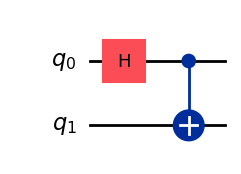

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0,1)

qc.draw(output='mpl')


In [3]:
from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')  
XX = Pauli('XX')
XI  = Pauli('XI')
IX = Pauli('IX')

observables = (ZZ,ZI,IZ,XX,XI,IX)


Step 2: Optimizied Circuit

Step 3: Execute on the backend

In [4]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([ 1.        ,  0.02148438,  0.02148438,  1.        , -0.01367188,
       -0.01367188]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'time_taken': 0.025584927, 'num_bind_params': 1, 'parallel_state_update': 2, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.000797639, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 6580, 'noise': 'ideal', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9995384216308594, 'simulator_metadata': [{'time_taken': 0.025584927, 'num_bind_params': 1, 'parallel_state_update': 2, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.000

# Step 4: Post-process(and plotting)

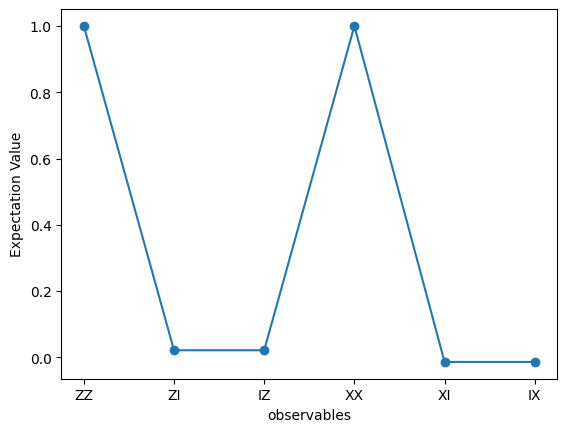

In [5]:
import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ','XX','XI','IX']
values = job.result().values

plt.plot(data,values,'-o')
plt.xlabel('observables')
plt.ylabel('Expectation Value')
plt.show()

        

# Extend Hello World to an n-qubit GHZ state

Step 1: Map the problem to ciercuis and operators

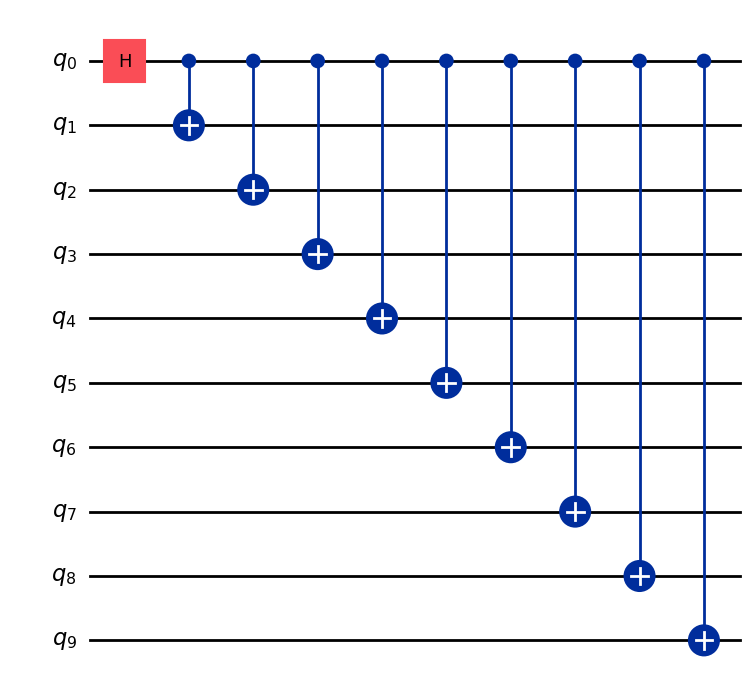

In [7]:
def get_qc_for_n_qubit_GHZ_stat(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(1,n):
        qc.cx(0,i)
    return qc

n = 10
qc = get_qc_for_n_qubit_GHZ_stat(n)
qc.draw(output='mpl')

In [8]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = ['Z' + 'I' * i +  'Z' + 'I' * (n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator_string) for operator_string in operator_strings]


['ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ']
9


# Call the service to submit the job

### login and instantiate the service

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService

token = '4c635c9b66b0ab2f37ce29d7bc33edc66f815847092ba236aa79748304b2cd4bbba6c35d8a4a6adc9b579b1990cfa8066f5220cbdc29044dc9bd59f1c1e1ea1b'
instance = 'ibm-q/open/main'

service = QiskitRuntimeService(
        channel='ibm_quantum',
        instance=instance,
        token=token
)
# Save an IBM Cloud account.
#QiskitRuntimeService.save_account(channel="ibm_cloud", token=token, 
#                                  instance=instance,
#                                  overwrite=True)

# Save your IBM Quantum API key
service.save_account(channel="ibm_quantum", 
                                  token=token,
                                  overwrite=True)



### Set up the service with backend and layout

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# token = '4c635c9b66b0ab2f37ce29d7bc33edc66f815847092ba236aa79748304b2cd4bbba6c35d8a4a6adc9b579b1990cfa8066f5220cbdc29044dc9bd59f1c1e1ea1b'
# instance = 'ibm-q/open/main'

# service = QiskitRuntimeService(
#         channel='ibm_quantum',
#         instance=instance,
#         token=token
# )

backend_name = 'ibm_brisbane'
backend = service.backend(backend_name)
pass_Manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_Manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]


### Execute on the backend and get job_id

In [14]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
# options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)

job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()
print(job_id)

cxw8m28wk6yg008j0030


### Get job info

In [ ]:
#job_id='cxw8m28wk6yg008j0030'#'cxqr6rk4a290008xkq2g'# 'cxr0sdn4a290008xmc60'
job = service.job(job_id)
print(job)

<RuntimeJobV2('cxw8m28wk6yg008j0030', 'estimator')>


### When job is done, Post-process and plot

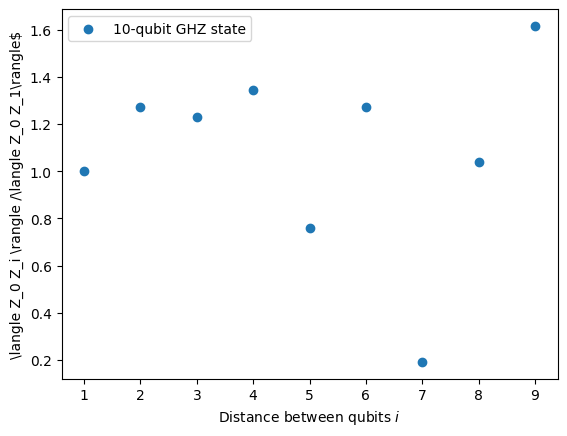

In [19]:
import matplotlib.pyplot as plt

data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = [v / values [0] for v in values]

plt.scatter(data, values, marker='o', label='10-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'\langle Z_0 Z_i \rangle /\langle Z_0 Z_1\rangle$')
plt. legend()
plt.show()

In [20]:
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: [0.59611111 0.7576087  0.73378076 0.80195865 0.45353982 0.759362
 0.11430396 0.61812298 0.96300716]
